In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import statistics as stats
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.models import Model
from keras import backend as K
from keras import backend, constraints
import tensorflow as tf
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras import optimizers
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
from random import randint
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import quality_metrics
from data_augmentation import Data

In [ ]:
"""!pip install -q kaggle
uploaded = files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ./kaggle.json
!kaggle datasets download -d hmchuong/xray-bone-shadow-supression
!mkdir xray-bone
!unzip xray-bone-shadow-supression.zip -d xray-bone"""

In [2]:
#bone_base_path = "/content/xray-bone/augmented/augmented/"
bone_base_path = "Dataset/"
source = "source/"
target = "target/"
bone_inputs = []
bone_outputs = []
i=0
for img in os.listdir(bone_base_path+source)[0:1000]:
    if i%500==0:
        print(i)
    i+=1
    im1 = cv2.bitwise_not(cv2.resize(cv2.imread(bone_base_path+source+img), (256,256)))
    im2 = cv2.bitwise_not(cv2.resize(cv2.imread(bone_base_path+target+img), (256,256)))
    bone_inputs.append(im1.reshape([256, 256, 3]))
    bone_outputs.append(im2.reshape([256, 256, 3]))
bone_Y = np.stack(bone_outputs, axis=0)
bone_Y = bone_Y/255.0
bone_X = np.stack(bone_inputs, axis=0)
bone_X = bone_X/255.0

0
500


In [3]:
#bone_X, bone_Y = Data(equalizer=False, normalizer='normal', skeleton=False).load_training_data()

## Discriminator

In [3]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5) #RMSprop(lr=0.00005)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5]) # 'binary_crossentropy', loss_weights=[0.5]
	return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
#plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6208        concatenate[0][0]            

## Generator model

In [4]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
 
# define image shape
image_shape = (256,256,3)
# create the model
model = define_generator(image_shape)
# summarize the model
model.summary()
# plot the model
#plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

## GAN compile

In [5]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,1000]) #['binary_crossentropy', 'mae']
	return model

In [6]:
image_shape = (256,256,3)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
#plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 256, 256, 3)  54429315    input_7[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16, 16, 1)    6968257     input_7[0][0]                    
                                                                 model_3[1][0]                    
Total params: 61,397,572
Trainable params: 54,419,459
Non-trainable params: 6,978,113
__________________________________________________________________________________________________


In [7]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
    trainA, trainB = dataset
    x1 = []
    x2 = []
  #print(trainA.shape[0])
  # choose random instances
    for j in range(n_samples):
        ix = randint(0, trainA.shape[0]-1)
        x1.append(trainA[ix])
        x2.append(trainB[ix])
    # retrieve selected images
    X1, X2 = np.stack(x1, axis=0), np.stack(x2, axis=0)
    #X1, X2 = trainA[ix].reshape((1,256,256,3)), trainB[ix].reshape((1,256,256,3))
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [8]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

## Train model

In [9]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1, n_patch=16):
	# unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    print(n_steps)
    d_real = []
    d_fake = []
    gan_loss = []
    for i in range(n_steps):
    # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        d_real.append(d_loss1)
        d_fake.append(d_loss2)
        gan_loss.append(g_loss)
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f] d3[%.3f]' % (i+1, d_loss1, d_loss2, g_loss, -d_loss2+d_loss1))
    return d_real, d_fake, gan_loss

In [10]:
start = time.time()
d_real, d_fake, gan_loss = train(d_model, g_model, gan_model, [bone_X, bone_Y], n_epochs=50, n_batch=8)
end = time.time()
print("Execution time = "+str(end-start))

6250
>1, d1[0.376] d2[0.748] g[835.815] d3[-0.372]
>2, d1[0.364] d2[0.907] g[824.761] d3[-0.543]
>3, d1[0.431] d2[0.493] g[780.070] d3[-0.062]
>4, d1[0.478] d2[0.325] g[765.495] d3[0.152]
>5, d1[0.350] d2[0.236] g[720.017] d3[0.114]
>6, d1[0.169] d2[0.200] g[712.482] d3[-0.032]
>7, d1[0.063] d2[0.256] g[671.418] d3[-0.193]
>8, d1[0.062] d2[0.171] g[631.327] d3[-0.109]
>9, d1[0.048] d2[0.085] g[617.612] d3[-0.037]
>10, d1[0.038] d2[0.032] g[569.242] d3[0.006]
>11, d1[0.026] d2[0.021] g[585.064] d3[0.005]
>12, d1[0.030] d2[0.021] g[547.358] d3[0.008]
>13, d1[0.019] d2[0.017] g[510.265] d3[0.002]
>14, d1[0.017] d2[0.018] g[487.346] d3[-0.001]
>15, d1[0.017] d2[0.018] g[461.345] d3[-0.001]
>16, d1[0.015] d2[0.020] g[442.536] d3[-0.005]
>17, d1[0.013] d2[0.015] g[395.840] d3[-0.002]
>18, d1[0.012] d2[0.015] g[367.857] d3[-0.003]
>19, d1[0.013] d2[0.019] g[346.341] d3[-0.006]
>20, d1[0.012] d2[0.019] g[327.653] d3[-0.008]
>21, d1[0.013] d2[0.011] g[285.165] d3[0.002]
>22, d1[0.011] d2[0.009]

>180, d1[0.045] d2[0.031] g[23.695] d3[0.014]
>181, d1[0.084] d2[0.025] g[31.359] d3[0.059]
>182, d1[0.025] d2[0.087] g[26.713] d3[-0.063]
>183, d1[0.235] d2[0.151] g[25.399] d3[0.085]
>184, d1[0.041] d2[0.399] g[21.509] d3[-0.358]
>185, d1[0.181] d2[0.019] g[20.223] d3[0.162]
>186, d1[0.115] d2[0.045] g[31.501] d3[0.070]
>187, d1[0.138] d2[0.062] g[20.586] d3[0.076]
>188, d1[0.024] d2[0.045] g[25.621] d3[-0.020]
>189, d1[0.062] d2[0.033] g[21.332] d3[0.029]
>190, d1[0.034] d2[0.053] g[24.875] d3[-0.019]
>191, d1[0.058] d2[0.028] g[25.826] d3[0.029]
>192, d1[0.034] d2[0.015] g[29.268] d3[0.019]
>193, d1[0.018] d2[0.015] g[24.665] d3[0.002]
>194, d1[0.032] d2[0.016] g[22.347] d3[0.016]
>195, d1[0.208] d2[1.119] g[19.857] d3[-0.911]
>196, d1[0.425] d2[0.255] g[31.202] d3[0.170]
>197, d1[0.182] d2[0.107] g[43.665] d3[0.075]
>198, d1[0.445] d2[1.469] g[39.872] d3[-1.024]
>199, d1[0.114] d2[0.377] g[26.976] d3[-0.263]
>200, d1[0.314] d2[0.050] g[25.533] d3[0.265]
>201, d1[0.271] d2[0.126] g

>357, d1[0.043] d2[0.010] g[27.757] d3[0.032]
>358, d1[0.013] d2[0.039] g[42.704] d3[-0.026]
>359, d1[0.007] d2[0.005] g[26.835] d3[0.002]
>360, d1[0.018] d2[0.006] g[25.311] d3[0.013]
>361, d1[0.048] d2[0.007] g[25.213] d3[0.040]
>362, d1[0.016] d2[0.017] g[21.381] d3[-0.001]
>363, d1[0.008] d2[0.016] g[25.365] d3[-0.008]
>364, d1[0.010] d2[0.016] g[27.245] d3[-0.006]
>365, d1[0.008] d2[0.004] g[25.117] d3[0.003]
>366, d1[0.132] d2[0.072] g[18.158] d3[0.060]
>367, d1[0.008] d2[0.019] g[22.760] d3[-0.011]
>368, d1[0.013] d2[0.012] g[29.589] d3[0.001]
>369, d1[0.018] d2[0.060] g[24.840] d3[-0.042]
>370, d1[0.008] d2[0.008] g[21.687] d3[-0.000]
>371, d1[0.061] d2[0.041] g[30.211] d3[0.020]
>372, d1[0.117] d2[0.041] g[25.948] d3[0.076]
>373, d1[0.016] d2[0.080] g[33.176] d3[-0.064]
>374, d1[0.023] d2[0.077] g[21.318] d3[-0.054]
>375, d1[0.019] d2[0.017] g[26.543] d3[0.002]
>376, d1[0.043] d2[0.005] g[24.662] d3[0.038]
>377, d1[0.065] d2[0.006] g[22.666] d3[0.059]
>378, d1[0.012] d2[0.004]

>534, d1[0.006] d2[0.005] g[20.308] d3[0.001]
>535, d1[0.005] d2[0.006] g[23.049] d3[-0.001]
>536, d1[0.020] d2[0.011] g[20.739] d3[0.010]
>537, d1[0.034] d2[0.012] g[17.298] d3[0.022]
>538, d1[0.020] d2[0.015] g[16.277] d3[0.005]
>539, d1[0.004] d2[0.008] g[18.630] d3[-0.004]
>540, d1[0.006] d2[0.024] g[20.462] d3[-0.017]
>541, d1[0.007] d2[0.010] g[23.150] d3[-0.004]
>542, d1[0.004] d2[0.009] g[23.285] d3[-0.005]
>543, d1[0.005] d2[0.006] g[23.172] d3[-0.001]
>544, d1[0.008] d2[0.018] g[20.325] d3[-0.010]
>545, d1[0.005] d2[0.007] g[20.281] d3[-0.002]
>546, d1[0.014] d2[0.005] g[20.803] d3[0.009]
>547, d1[0.018] d2[0.005] g[17.614] d3[0.014]
>548, d1[0.019] d2[0.005] g[20.956] d3[0.014]
>549, d1[0.004] d2[0.005] g[21.745] d3[-0.002]
>550, d1[0.011] d2[0.005] g[17.788] d3[0.006]
>551, d1[0.050] d2[0.023] g[14.440] d3[0.027]
>552, d1[0.009] d2[0.014] g[16.413] d3[-0.005]
>553, d1[0.131] d2[0.060] g[14.175] d3[0.071]
>554, d1[0.002] d2[0.017] g[24.184] d3[-0.015]
>555, d1[0.002] d2[0.06

>711, d1[0.005] d2[0.006] g[19.812] d3[-0.000]
>712, d1[0.032] d2[0.008] g[16.666] d3[0.024]
>713, d1[0.020] d2[0.012] g[15.803] d3[0.009]
>714, d1[0.013] d2[0.007] g[20.878] d3[0.006]
>715, d1[0.016] d2[0.005] g[17.615] d3[0.011]
>716, d1[0.006] d2[0.018] g[21.022] d3[-0.013]
>717, d1[0.017] d2[0.004] g[24.423] d3[0.013]
>718, d1[0.005] d2[0.004] g[15.419] d3[0.001]
>719, d1[0.002] d2[0.004] g[18.551] d3[-0.003]
>720, d1[0.002] d2[0.005] g[21.388] d3[-0.003]
>721, d1[0.003] d2[0.008] g[15.521] d3[-0.005]
>722, d1[0.004] d2[0.007] g[25.745] d3[-0.003]
>723, d1[0.004] d2[0.038] g[18.063] d3[-0.034]
>724, d1[0.055] d2[0.047] g[23.122] d3[0.007]
>725, d1[0.344] d2[0.550] g[18.018] d3[-0.206]
>726, d1[0.005] d2[0.122] g[20.517] d3[-0.117]
>727, d1[0.037] d2[0.040] g[20.459] d3[-0.002]
>728, d1[0.049] d2[0.035] g[21.930] d3[0.015]
>729, d1[0.039] d2[0.008] g[16.924] d3[0.031]
>730, d1[0.050] d2[0.007] g[15.631] d3[0.043]
>731, d1[0.009] d2[0.004] g[16.989] d3[0.005]
>732, d1[0.011] d2[0.012

>888, d1[0.020] d2[0.009] g[18.924] d3[0.011]
>889, d1[0.004] d2[0.004] g[25.033] d3[-0.000]
>890, d1[0.009] d2[0.008] g[20.197] d3[0.001]
>891, d1[0.022] d2[0.007] g[18.895] d3[0.015]
>892, d1[0.015] d2[0.005] g[18.837] d3[0.010]
>893, d1[0.004] d2[0.004] g[22.198] d3[-0.000]
>894, d1[0.004] d2[0.010] g[20.103] d3[-0.006]
>895, d1[0.001] d2[0.008] g[24.804] d3[-0.007]
>896, d1[0.170] d2[0.179] g[23.874] d3[-0.010]
>897, d1[0.003] d2[0.043] g[27.586] d3[-0.041]
>898, d1[0.039] d2[0.005] g[19.808] d3[0.034]
>899, d1[0.011] d2[0.023] g[21.704] d3[-0.011]
>900, d1[0.004] d2[0.007] g[26.352] d3[-0.003]
>901, d1[0.111] d2[0.013] g[16.856] d3[0.098]
>902, d1[0.005] d2[0.037] g[22.942] d3[-0.032]
>903, d1[0.010] d2[0.027] g[13.804] d3[-0.017]
>904, d1[0.001] d2[0.036] g[21.383] d3[-0.035]
>905, d1[0.001] d2[0.005] g[32.725] d3[-0.003]
>906, d1[0.005] d2[0.005] g[27.005] d3[-0.000]
>907, d1[0.036] d2[0.015] g[16.798] d3[0.022]
>908, d1[0.139] d2[0.028] g[15.169] d3[0.111]
>909, d1[0.002] d2[0.

>1063, d1[0.020] d2[0.026] g[15.667] d3[-0.006]
>1064, d1[0.006] d2[0.006] g[25.843] d3[0.000]
>1065, d1[0.068] d2[0.009] g[13.273] d3[0.058]
>1066, d1[0.002] d2[0.024] g[18.824] d3[-0.022]
>1067, d1[0.043] d2[0.071] g[23.160] d3[-0.027]
>1068, d1[0.007] d2[0.004] g[20.917] d3[0.003]
>1069, d1[0.007] d2[0.012] g[15.944] d3[-0.005]
>1070, d1[0.020] d2[0.022] g[25.437] d3[-0.002]
>1071, d1[0.058] d2[0.005] g[19.543] d3[0.052]
>1072, d1[0.004] d2[0.016] g[17.097] d3[-0.013]
>1073, d1[0.002] d2[0.007] g[18.265] d3[-0.005]
>1074, d1[0.010] d2[0.009] g[18.080] d3[0.001]
>1075, d1[0.687] d2[1.205] g[19.673] d3[-0.518]
>1076, d1[0.118] d2[0.055] g[16.905] d3[0.063]
>1077, d1[0.008] d2[0.013] g[19.297] d3[-0.005]
>1078, d1[0.023] d2[0.009] g[19.284] d3[0.014]
>1079, d1[0.034] d2[0.013] g[23.098] d3[0.021]
>1080, d1[0.009] d2[0.020] g[15.510] d3[-0.011]
>1081, d1[0.012] d2[0.023] g[19.898] d3[-0.011]
>1082, d1[0.046] d2[0.008] g[14.472] d3[0.038]
>1083, d1[0.051] d2[0.026] g[23.539] d3[0.026]
>1

>1236, d1[0.005] d2[0.007] g[14.374] d3[-0.002]
>1237, d1[0.002] d2[0.008] g[24.684] d3[-0.006]
>1238, d1[0.016] d2[0.004] g[22.188] d3[0.012]
>1239, d1[0.022] d2[0.004] g[18.536] d3[0.019]
>1240, d1[0.016] d2[0.005] g[15.304] d3[0.012]
>1241, d1[0.015] d2[0.003] g[13.621] d3[0.012]
>1242, d1[0.002] d2[0.012] g[12.929] d3[-0.009]
>1243, d1[0.010] d2[0.006] g[13.001] d3[0.003]
>1244, d1[0.001] d2[0.010] g[22.386] d3[-0.009]
>1245, d1[0.005] d2[0.004] g[17.946] d3[0.001]
>1246, d1[0.001] d2[0.007] g[15.820] d3[-0.006]
>1247, d1[0.002] d2[0.011] g[14.453] d3[-0.009]
>1248, d1[0.006] d2[0.020] g[14.440] d3[-0.014]
>1249, d1[0.041] d2[0.005] g[14.650] d3[0.036]
>1250, d1[0.030] d2[0.008] g[12.282] d3[0.022]
>1251, d1[0.001] d2[0.011] g[19.947] d3[-0.010]
>1252, d1[0.001] d2[0.016] g[27.437] d3[-0.015]
>1253, d1[0.002] d2[0.102] g[17.542] d3[-0.100]
>1254, d1[1.118] d2[0.927] g[17.349] d3[0.192]
>1255, d1[0.005] d2[0.184] g[27.578] d3[-0.179]
>1256, d1[0.580] d2[0.326] g[14.082] d3[0.253]
>1

>1409, d1[0.011] d2[0.029] g[16.289] d3[-0.018]
>1410, d1[0.020] d2[0.014] g[16.275] d3[0.006]
>1411, d1[0.012] d2[0.016] g[20.479] d3[-0.005]
>1412, d1[0.004] d2[0.008] g[20.865] d3[-0.004]
>1413, d1[0.215] d2[0.059] g[14.281] d3[0.156]
>1414, d1[0.142] d2[0.536] g[20.294] d3[-0.394]
>1415, d1[0.261] d2[0.072] g[13.810] d3[0.189]
>1416, d1[0.042] d2[0.073] g[30.560] d3[-0.031]
>1417, d1[0.113] d2[0.006] g[13.707] d3[0.107]
>1418, d1[0.037] d2[0.014] g[20.542] d3[0.023]
>1419, d1[0.046] d2[0.016] g[17.343] d3[0.029]
>1420, d1[0.023] d2[0.011] g[20.348] d3[0.011]
>1421, d1[0.005] d2[0.022] g[15.488] d3[-0.017]
>1422, d1[0.002] d2[0.016] g[19.842] d3[-0.014]
>1423, d1[0.003] d2[0.015] g[15.513] d3[-0.011]
>1424, d1[0.143] d2[0.030] g[17.812] d3[0.113]
>1425, d1[0.003] d2[0.027] g[15.704] d3[-0.024]
>1426, d1[0.032] d2[0.012] g[17.173] d3[0.020]
>1427, d1[0.018] d2[0.011] g[33.330] d3[0.007]
>1428, d1[0.011] d2[0.018] g[26.862] d3[-0.006]
>1429, d1[0.006] d2[0.037] g[18.245] d3[-0.031]
>1

>1582, d1[0.001] d2[0.016] g[24.340] d3[-0.016]
>1583, d1[0.001] d2[0.030] g[21.494] d3[-0.029]
>1584, d1[0.001] d2[0.015] g[27.328] d3[-0.014]
>1585, d1[0.004] d2[0.010] g[18.553] d3[-0.006]
>1586, d1[0.023] d2[0.009] g[15.524] d3[0.013]
>1587, d1[0.010] d2[0.005] g[13.772] d3[0.005]
>1588, d1[0.024] d2[0.011] g[15.541] d3[0.013]
>1589, d1[0.966] d2[1.419] g[16.233] d3[-0.453]
>1590, d1[0.029] d2[0.057] g[12.771] d3[-0.028]
>1591, d1[0.007] d2[0.013] g[20.106] d3[-0.006]
>1592, d1[0.229] d2[0.039] g[19.938] d3[0.191]
>1593, d1[0.020] d2[0.209] g[19.598] d3[-0.189]
>1594, d1[0.020] d2[0.011] g[14.169] d3[0.009]
>1595, d1[0.027] d2[0.018] g[16.068] d3[0.010]
>1596, d1[0.035] d2[0.017] g[17.627] d3[0.019]
>1597, d1[0.037] d2[0.013] g[16.641] d3[0.023]
>1598, d1[0.006] d2[0.044] g[17.542] d3[-0.039]
>1599, d1[0.005] d2[0.007] g[16.111] d3[-0.002]
>1600, d1[0.060] d2[0.004] g[13.699] d3[0.056]
>1601, d1[0.006] d2[0.016] g[14.558] d3[-0.010]
>1602, d1[0.002] d2[0.006] g[18.573] d3[-0.004]
>

>1755, d1[0.011] d2[0.007] g[20.852] d3[0.004]
>1756, d1[0.004] d2[0.001] g[15.867] d3[0.003]
>1757, d1[0.003] d2[0.002] g[15.706] d3[0.001]
>1758, d1[0.002] d2[0.002] g[13.971] d3[0.001]
>1759, d1[0.037] d2[0.004] g[12.732] d3[0.033]
>1760, d1[0.018] d2[0.008] g[13.342] d3[0.009]
>1761, d1[0.001] d2[0.003] g[16.705] d3[-0.002]
>1762, d1[0.012] d2[0.003] g[16.431] d3[0.009]
>1763, d1[0.004] d2[0.005] g[20.537] d3[-0.001]
>1764, d1[0.022] d2[0.061] g[16.854] d3[-0.039]
>1765, d1[0.003] d2[0.013] g[21.855] d3[-0.010]
>1766, d1[0.001] d2[0.004] g[17.463] d3[-0.002]
>1767, d1[0.008] d2[0.001] g[16.481] d3[0.007]
>1768, d1[0.004] d2[0.002] g[13.187] d3[0.003]
>1769, d1[0.077] d2[0.012] g[14.975] d3[0.065]
>1770, d1[0.170] d2[0.030] g[19.594] d3[0.140]
>1771, d1[0.001] d2[0.321] g[21.496] d3[-0.320]
>1772, d1[0.135] d2[0.870] g[17.110] d3[-0.735]
>1773, d1[0.416] d2[0.082] g[46.762] d3[0.334]
>1774, d1[0.162] d2[0.282] g[17.187] d3[-0.120]
>1775, d1[0.235] d2[0.022] g[23.478] d3[0.213]
>1776

>1928, d1[0.023] d2[0.001] g[12.922] d3[0.022]
>1929, d1[0.026] d2[0.003] g[12.348] d3[0.023]
>1930, d1[0.002] d2[0.003] g[15.763] d3[-0.001]
>1931, d1[0.002] d2[0.006] g[18.532] d3[-0.004]
>1932, d1[0.003] d2[0.004] g[13.246] d3[-0.001]
>1933, d1[0.004] d2[0.006] g[15.409] d3[-0.001]
>1934, d1[0.001] d2[0.003] g[14.450] d3[-0.002]
>1935, d1[0.094] d2[0.024] g[13.726] d3[0.070]
>1936, d1[0.002] d2[0.071] g[14.025] d3[-0.069]
>1937, d1[0.003] d2[0.007] g[15.799] d3[-0.004]
>1938, d1[0.054] d2[0.017] g[13.505] d3[0.037]
>1939, d1[0.062] d2[0.004] g[16.589] d3[0.057]
>1940, d1[0.007] d2[0.013] g[24.131] d3[-0.006]
>1941, d1[0.001] d2[0.005] g[25.363] d3[-0.005]
>1942, d1[0.001] d2[0.017] g[18.898] d3[-0.016]
>1943, d1[0.001] d2[0.070] g[25.830] d3[-0.069]
>1944, d1[0.005] d2[0.002] g[16.787] d3[0.003]
>1945, d1[0.031] d2[0.002] g[13.692] d3[0.029]
>1946, d1[0.002] d2[0.010] g[24.726] d3[-0.008]
>1947, d1[0.002] d2[0.011] g[14.910] d3[-0.009]
>1948, d1[0.003] d2[0.004] g[16.083] d3[-0.001]

>2101, d1[0.009] d2[0.008] g[20.379] d3[0.001]
>2102, d1[0.003] d2[0.010] g[15.121] d3[-0.007]
>2103, d1[0.031] d2[0.009] g[14.129] d3[0.022]
>2104, d1[0.002] d2[0.011] g[16.869] d3[-0.009]
>2105, d1[0.002] d2[0.011] g[17.436] d3[-0.009]
>2106, d1[0.168] d2[0.012] g[23.962] d3[0.156]
>2107, d1[0.001] d2[0.038] g[17.144] d3[-0.036]
>2108, d1[0.001] d2[0.009] g[19.214] d3[-0.008]
>2109, d1[0.005] d2[0.009] g[15.477] d3[-0.004]
>2110, d1[0.001] d2[0.041] g[23.132] d3[-0.040]
>2111, d1[0.001] d2[0.003] g[17.648] d3[-0.001]
>2112, d1[0.024] d2[0.001] g[15.644] d3[0.023]
>2113, d1[0.005] d2[0.002] g[19.539] d3[0.003]
>2114, d1[0.009] d2[0.002] g[13.206] d3[0.008]
>2115, d1[0.003] d2[0.003] g[15.660] d3[-0.000]
>2116, d1[0.001] d2[0.004] g[15.323] d3[-0.003]
>2117, d1[0.000] d2[0.007] g[20.328] d3[-0.006]
>2118, d1[0.001] d2[0.034] g[29.975] d3[-0.033]
>2119, d1[0.001] d2[0.004] g[16.668] d3[-0.003]
>2120, d1[0.008] d2[0.003] g[23.639] d3[0.005]
>2121, d1[0.003] d2[0.003] g[19.694] d3[-0.000]

>2274, d1[0.560] d2[0.827] g[16.826] d3[-0.267]
>2275, d1[0.393] d2[0.013] g[22.443] d3[0.380]
>2276, d1[0.006] d2[0.046] g[12.826] d3[-0.040]
>2277, d1[0.007] d2[0.008] g[15.178] d3[-0.001]
>2278, d1[0.018] d2[0.009] g[13.580] d3[0.009]
>2279, d1[0.091] d2[0.005] g[12.867] d3[0.086]
>2280, d1[0.039] d2[0.011] g[10.353] d3[0.028]
>2281, d1[0.109] d2[0.028] g[12.433] d3[0.081]
>2282, d1[0.003] d2[0.296] g[13.977] d3[-0.293]
>2283, d1[0.049] d2[0.010] g[12.401] d3[0.039]
>2284, d1[0.747] d2[0.035] g[11.578] d3[0.712]
>2285, d1[0.001] d2[0.206] g[31.235] d3[-0.205]
>2286, d1[0.005] d2[0.127] g[17.092] d3[-0.122]
>2287, d1[0.006] d2[0.036] g[20.763] d3[-0.031]
>2288, d1[0.012] d2[0.010] g[18.264] d3[0.002]
>2289, d1[0.013] d2[0.004] g[19.783] d3[0.009]
>2290, d1[0.133] d2[0.014] g[14.946] d3[0.120]
>2291, d1[0.005] d2[0.071] g[21.578] d3[-0.067]
>2292, d1[0.005] d2[0.029] g[13.993] d3[-0.024]
>2293, d1[0.006] d2[0.018] g[15.947] d3[-0.012]
>2294, d1[0.107] d2[0.019] g[14.273] d3[0.088]
>22

>2447, d1[0.000] d2[0.011] g[35.174] d3[-0.010]
>2448, d1[0.001] d2[0.010] g[21.391] d3[-0.009]
>2449, d1[0.001] d2[0.162] g[20.122] d3[-0.161]
>2450, d1[0.005] d2[0.016] g[23.022] d3[-0.011]
>2451, d1[0.002] d2[0.003] g[17.603] d3[-0.001]
>2452, d1[0.042] d2[0.006] g[12.795] d3[0.035]
>2453, d1[0.597] d2[2.202] g[15.397] d3[-1.604]
>2454, d1[0.181] d2[0.105] g[12.363] d3[0.077]
>2455, d1[0.024] d2[0.077] g[13.680] d3[-0.054]
>2456, d1[0.142] d2[0.004] g[16.876] d3[0.138]
>2457, d1[0.012] d2[0.001] g[16.353] d3[0.011]
>2458, d1[0.023] d2[0.005] g[12.575] d3[0.018]
>2459, d1[0.003] d2[0.015] g[15.945] d3[-0.011]
>2460, d1[0.011] d2[0.007] g[12.383] d3[0.004]
>2461, d1[0.030] d2[0.011] g[16.190] d3[0.018]
>2462, d1[0.006] d2[0.003] g[12.059] d3[0.003]
>2463, d1[0.024] d2[0.012] g[21.474] d3[0.012]
>2464, d1[0.031] d2[0.024] g[11.874] d3[0.006]
>2465, d1[0.005] d2[0.024] g[13.217] d3[-0.019]
>2466, d1[0.076] d2[0.005] g[14.002] d3[0.071]
>2467, d1[0.003] d2[0.021] g[15.082] d3[-0.018]
>24

>2620, d1[0.385] d2[0.102] g[13.419] d3[0.283]
>2621, d1[0.003] d2[0.019] g[17.406] d3[-0.016]
>2622, d1[0.000] d2[0.020] g[20.310] d3[-0.019]
>2623, d1[0.002] d2[0.012] g[11.819] d3[-0.010]
>2624, d1[0.003] d2[0.004] g[13.841] d3[-0.001]
>2625, d1[0.002] d2[0.013] g[24.771] d3[-0.011]
>2626, d1[0.005] d2[0.002] g[14.856] d3[0.003]
>2627, d1[0.002] d2[0.004] g[12.556] d3[-0.003]
>2628, d1[0.001] d2[0.002] g[12.218] d3[-0.001]
>2629, d1[0.005] d2[0.001] g[12.529] d3[0.004]
>2630, d1[0.002] d2[0.003] g[15.268] d3[-0.001]
>2631, d1[0.008] d2[0.010] g[13.502] d3[-0.002]
>2632, d1[0.001] d2[0.033] g[16.864] d3[-0.032]
>2633, d1[0.001] d2[0.040] g[15.217] d3[-0.040]
>2634, d1[0.002] d2[0.025] g[14.845] d3[-0.023]
>2635, d1[0.032] d2[0.002] g[15.363] d3[0.030]
>2636, d1[0.001] d2[0.005] g[14.997] d3[-0.004]
>2637, d1[0.029] d2[0.001] g[18.451] d3[0.027]
>2638, d1[0.003] d2[0.008] g[15.124] d3[-0.005]
>2639, d1[0.003] d2[0.006] g[14.849] d3[-0.003]
>2640, d1[0.003] d2[0.005] g[29.058] d3[-0.00

>2793, d1[0.001] d2[0.002] g[11.829] d3[-0.001]
>2794, d1[0.001] d2[0.001] g[13.573] d3[-0.000]
>2795, d1[0.001] d2[0.005] g[15.791] d3[-0.004]
>2796, d1[0.001] d2[0.025] g[14.657] d3[-0.024]
>2797, d1[0.002] d2[0.006] g[17.576] d3[-0.005]
>2798, d1[0.001] d2[0.001] g[12.819] d3[0.000]
>2799, d1[0.001] d2[0.001] g[14.240] d3[-0.000]
>2800, d1[0.009] d2[0.023] g[13.915] d3[-0.014]
>2801, d1[0.005] d2[0.003] g[21.068] d3[0.002]
>2802, d1[0.003] d2[0.001] g[12.615] d3[0.002]
>2803, d1[0.000] d2[0.001] g[14.246] d3[-0.001]
>2804, d1[0.004] d2[0.002] g[15.092] d3[0.002]
>2805, d1[0.002] d2[0.000] g[14.553] d3[0.001]
>2806, d1[0.006] d2[0.001] g[14.111] d3[0.005]
>2807, d1[0.006] d2[0.001] g[14.106] d3[0.004]
>2808, d1[0.008] d2[0.001] g[15.065] d3[0.008]
>2809, d1[0.001] d2[0.001] g[12.890] d3[-0.000]
>2810, d1[0.001] d2[0.001] g[18.853] d3[-0.000]
>2811, d1[0.002] d2[0.000] g[11.772] d3[0.002]
>2812, d1[0.005] d2[0.000] g[10.742] d3[0.005]
>2813, d1[0.022] d2[0.013] g[16.357] d3[0.009]
>28

>2966, d1[0.026] d2[0.002] g[12.559] d3[0.024]
>2967, d1[0.002] d2[0.002] g[11.480] d3[-0.000]
>2968, d1[0.002] d2[0.002] g[16.876] d3[-0.000]
>2969, d1[0.000] d2[0.005] g[12.832] d3[-0.005]
>2970, d1[0.005] d2[0.006] g[16.672] d3[-0.000]
>2971, d1[0.122] d2[0.009] g[11.700] d3[0.112]
>2972, d1[0.000] d2[0.057] g[19.936] d3[-0.057]
>2973, d1[0.000] d2[0.027] g[11.650] d3[-0.027]
>2974, d1[0.000] d2[0.003] g[11.313] d3[-0.003]
>2975, d1[0.143] d2[0.704] g[19.559] d3[-0.561]
>2976, d1[0.243] d2[0.004] g[11.244] d3[0.239]
>2977, d1[0.272] d2[0.063] g[20.924] d3[0.210]
>2978, d1[0.009] d2[0.028] g[13.149] d3[-0.019]
>2979, d1[0.021] d2[0.011] g[15.641] d3[0.010]
>2980, d1[0.000] d2[0.004] g[12.761] d3[-0.004]
>2981, d1[0.004] d2[0.004] g[10.126] d3[-0.000]
>2982, d1[0.011] d2[0.013] g[14.206] d3[-0.002]
>2983, d1[0.012] d2[0.018] g[14.485] d3[-0.006]
>2984, d1[0.003] d2[0.010] g[18.134] d3[-0.007]
>2985, d1[0.006] d2[0.001] g[13.439] d3[0.005]
>2986, d1[0.001] d2[0.002] g[14.273] d3[-0.001

>3139, d1[0.012] d2[0.023] g[9.501] d3[-0.011]
>3140, d1[0.002] d2[0.002] g[12.521] d3[0.000]
>3141, d1[0.001] d2[0.009] g[15.321] d3[-0.008]
>3142, d1[0.000] d2[0.004] g[20.271] d3[-0.004]
>3143, d1[0.000] d2[0.003] g[12.596] d3[-0.003]
>3144, d1[0.001] d2[0.005] g[11.673] d3[-0.004]
>3145, d1[0.000] d2[0.006] g[12.682] d3[-0.006]
>3146, d1[0.001] d2[0.001] g[12.026] d3[-0.000]
>3147, d1[0.000] d2[0.002] g[11.448] d3[-0.001]
>3148, d1[0.002] d2[0.006] g[13.665] d3[-0.003]
>3149, d1[0.002] d2[0.001] g[11.457] d3[0.001]
>3150, d1[0.008] d2[0.002] g[11.044] d3[0.006]
>3151, d1[0.004] d2[0.001] g[13.904] d3[0.003]
>3152, d1[0.000] d2[0.002] g[34.363] d3[-0.002]
>3153, d1[0.000] d2[0.007] g[15.238] d3[-0.007]
>3154, d1[0.003] d2[0.002] g[12.443] d3[0.001]
>3155, d1[0.000] d2[0.003] g[10.805] d3[-0.002]
>3156, d1[0.003] d2[0.007] g[10.753] d3[-0.004]
>3157, d1[0.003] d2[0.002] g[20.133] d3[0.000]
>3158, d1[0.006] d2[0.001] g[12.824] d3[0.005]
>3159, d1[0.008] d2[0.001] g[17.833] d3[0.007]
>

>3312, d1[0.000] d2[0.003] g[11.032] d3[-0.002]
>3313, d1[0.200] d2[0.038] g[11.974] d3[0.162]
>3314, d1[0.000] d2[0.036] g[22.282] d3[-0.036]
>3315, d1[0.001] d2[0.043] g[17.472] d3[-0.042]
>3316, d1[0.002] d2[0.126] g[22.248] d3[-0.124]
>3317, d1[0.006] d2[0.001] g[12.539] d3[0.004]
>3318, d1[0.002] d2[0.001] g[23.460] d3[0.001]
>3319, d1[0.099] d2[0.002] g[18.258] d3[0.098]
>3320, d1[0.014] d2[0.005] g[15.093] d3[0.008]
>3321, d1[0.480] d2[0.515] g[10.772] d3[-0.035]
>3322, d1[0.000] d2[0.023] g[11.611] d3[-0.023]
>3323, d1[0.000] d2[0.002] g[13.802] d3[-0.001]
>3324, d1[0.108] d2[0.004] g[10.279] d3[0.104]
>3325, d1[0.001] d2[0.009] g[15.899] d3[-0.008]
>3326, d1[0.000] d2[0.014] g[11.131] d3[-0.014]
>3327, d1[0.044] d2[0.007] g[19.802] d3[0.037]
>3328, d1[0.001] d2[0.011] g[9.815] d3[-0.010]
>3329, d1[0.000] d2[0.001] g[15.644] d3[-0.001]
>3330, d1[0.001] d2[0.011] g[11.116] d3[-0.010]
>3331, d1[0.014] d2[0.002] g[13.778] d3[0.012]
>3332, d1[0.000] d2[0.001] g[15.946] d3[-0.001]
>

>3485, d1[0.001] d2[0.001] g[19.616] d3[-0.000]
>3486, d1[0.000] d2[0.001] g[15.473] d3[-0.001]
>3487, d1[0.005] d2[0.001] g[10.561] d3[0.004]
>3488, d1[0.612] d2[3.859] g[13.545] d3[-3.246]
>3489, d1[0.005] d2[0.738] g[10.494] d3[-0.734]
>3490, d1[0.467] d2[0.021] g[16.069] d3[0.446]
>3491, d1[0.315] d2[0.127] g[12.855] d3[0.188]
>3492, d1[0.371] d2[0.298] g[9.969] d3[0.073]
>3493, d1[0.003] d2[0.244] g[12.175] d3[-0.241]
>3494, d1[0.059] d2[0.001] g[14.332] d3[0.058]
>3495, d1[0.005] d2[0.005] g[17.797] d3[0.000]
>3496, d1[0.342] d2[0.023] g[24.574] d3[0.318]
>3497, d1[0.008] d2[0.205] g[11.360] d3[-0.197]
>3498, d1[0.089] d2[0.089] g[11.475] d3[-0.001]
>3499, d1[0.009] d2[0.002] g[12.393] d3[0.007]
>3500, d1[0.002] d2[0.000] g[11.510] d3[0.002]
>3501, d1[0.003] d2[0.001] g[11.984] d3[0.002]
>3502, d1[0.004] d2[0.001] g[11.221] d3[0.003]
>3503, d1[0.007] d2[0.004] g[16.967] d3[0.003]
>3504, d1[0.004] d2[0.001] g[14.444] d3[0.004]
>3505, d1[0.020] d2[0.003] g[13.563] d3[0.017]
>3506, 

>3658, d1[0.070] d2[0.008] g[12.476] d3[0.062]
>3659, d1[0.004] d2[0.071] g[13.216] d3[-0.067]
>3660, d1[0.004] d2[0.004] g[12.209] d3[0.000]
>3661, d1[0.001] d2[0.017] g[13.635] d3[-0.016]
>3662, d1[0.002] d2[0.007] g[19.093] d3[-0.005]
>3663, d1[0.001] d2[0.001] g[10.329] d3[-0.000]
>3664, d1[0.001] d2[0.001] g[11.330] d3[-0.001]
>3665, d1[0.000] d2[0.002] g[17.343] d3[-0.001]
>3666, d1[0.387] d2[0.341] g[11.904] d3[0.045]
>3667, d1[0.000] d2[0.028] g[14.901] d3[-0.028]
>3668, d1[0.001] d2[0.019] g[19.122] d3[-0.018]
>3669, d1[0.001] d2[0.012] g[15.604] d3[-0.011]
>3670, d1[0.002] d2[0.017] g[16.544] d3[-0.015]
>3671, d1[0.004] d2[0.001] g[12.666] d3[0.002]
>3672, d1[0.001] d2[0.013] g[12.942] d3[-0.012]
>3673, d1[0.026] d2[0.001] g[16.404] d3[0.025]
>3674, d1[0.000] d2[0.001] g[17.223] d3[-0.001]
>3675, d1[0.006] d2[0.007] g[12.811] d3[-0.002]
>3676, d1[0.006] d2[0.021] g[11.996] d3[-0.015]
>3677, d1[0.001] d2[0.000] g[11.215] d3[0.000]
>3678, d1[0.001] d2[0.001] g[14.243] d3[-0.001

>3831, d1[0.002] d2[0.002] g[11.323] d3[-0.000]
>3832, d1[0.003] d2[0.001] g[11.482] d3[0.002]
>3833, d1[0.013] d2[0.001] g[12.592] d3[0.012]
>3834, d1[0.000] d2[0.005] g[11.781] d3[-0.005]
>3835, d1[0.012] d2[0.001] g[14.532] d3[0.012]
>3836, d1[0.000] d2[0.019] g[9.828] d3[-0.018]
>3837, d1[0.003] d2[0.001] g[9.969] d3[0.003]
>3838, d1[0.005] d2[0.002] g[12.577] d3[0.003]
>3839, d1[0.459] d2[2.714] g[10.660] d3[-2.255]
>3840, d1[0.031] d2[0.016] g[12.322] d3[0.015]
>3841, d1[0.002] d2[0.009] g[16.428] d3[-0.008]
>3842, d1[0.375] d2[0.021] g[15.223] d3[0.354]
>3843, d1[0.006] d2[0.088] g[18.242] d3[-0.082]
>3844, d1[0.154] d2[0.010] g[11.672] d3[0.144]
>3845, d1[0.000] d2[0.231] g[13.144] d3[-0.231]
>3846, d1[0.000] d2[0.042] g[16.520] d3[-0.042]
>3847, d1[0.002] d2[0.037] g[15.404] d3[-0.035]
>3848, d1[0.016] d2[0.001] g[11.327] d3[0.015]
>3849, d1[0.002] d2[0.001] g[21.703] d3[0.001]
>3850, d1[0.001] d2[0.004] g[12.615] d3[-0.003]
>3851, d1[0.001] d2[0.003] g[14.252] d3[-0.003]
>385

>4004, d1[1.585] d2[0.258] g[12.755] d3[1.327]
>4005, d1[0.000] d2[0.462] g[13.438] d3[-0.461]
>4006, d1[0.001] d2[0.013] g[22.203] d3[-0.011]
>4007, d1[0.001] d2[0.012] g[12.395] d3[-0.011]
>4008, d1[0.013] d2[0.003] g[13.362] d3[0.010]
>4009, d1[0.002] d2[0.001] g[11.350] d3[0.000]
>4010, d1[0.029] d2[0.001] g[11.593] d3[0.028]
>4011, d1[0.013] d2[0.015] g[10.045] d3[-0.002]
>4012, d1[0.009] d2[0.012] g[11.622] d3[-0.003]
>4013, d1[0.010] d2[0.030] g[11.685] d3[-0.020]
>4014, d1[0.001] d2[0.001] g[12.397] d3[-0.000]
>4015, d1[0.007] d2[0.001] g[13.279] d3[0.005]
>4016, d1[0.001] d2[0.001] g[27.850] d3[-0.000]
>4017, d1[0.032] d2[0.005] g[13.118] d3[0.027]
>4018, d1[0.003] d2[0.009] g[14.692] d3[-0.006]
>4019, d1[0.001] d2[0.010] g[13.023] d3[-0.009]
>4020, d1[0.006] d2[0.002] g[11.405] d3[0.004]
>4021, d1[0.000] d2[0.002] g[16.629] d3[-0.002]
>4022, d1[0.000] d2[0.003] g[25.154] d3[-0.003]
>4023, d1[0.009] d2[0.003] g[10.357] d3[0.006]
>4024, d1[0.001] d2[0.002] g[11.823] d3[-0.001]


>4177, d1[0.068] d2[0.006] g[14.397] d3[0.062]
>4178, d1[0.003] d2[0.026] g[13.047] d3[-0.023]
>4179, d1[0.003] d2[0.007] g[17.338] d3[-0.004]
>4180, d1[0.003] d2[0.002] g[16.588] d3[0.000]
>4181, d1[0.055] d2[0.036] g[11.852] d3[0.018]
>4182, d1[0.004] d2[0.007] g[13.475] d3[-0.003]
>4183, d1[0.014] d2[0.012] g[13.871] d3[0.002]
>4184, d1[0.005] d2[0.006] g[14.430] d3[-0.002]
>4185, d1[0.878] d2[2.518] g[12.314] d3[-1.640]
>4186, d1[0.005] d2[0.010] g[11.063] d3[-0.005]
>4187, d1[0.152] d2[0.004] g[13.038] d3[0.148]
>4188, d1[0.049] d2[0.020] g[10.539] d3[0.029]
>4189, d1[0.053] d2[0.018] g[12.790] d3[0.035]
>4190, d1[0.001] d2[0.156] g[11.915] d3[-0.155]
>4191, d1[0.002] d2[0.019] g[12.299] d3[-0.017]
>4192, d1[0.096] d2[0.001] g[21.523] d3[0.095]
>4193, d1[0.008] d2[0.005] g[17.972] d3[0.003]
>4194, d1[0.012] d2[0.021] g[12.729] d3[-0.009]
>4195, d1[0.009] d2[0.002] g[17.040] d3[0.007]
>4196, d1[0.009] d2[0.006] g[18.591] d3[0.004]
>4197, d1[0.040] d2[0.002] g[12.283] d3[0.038]
>419

>4350, d1[0.560] d2[0.048] g[17.946] d3[0.512]
>4351, d1[0.000] d2[0.454] g[11.812] d3[-0.454]
>4352, d1[0.003] d2[0.007] g[11.691] d3[-0.004]
>4353, d1[0.006] d2[0.002] g[14.774] d3[0.003]
>4354, d1[0.006] d2[0.005] g[11.839] d3[0.002]
>4355, d1[0.224] d2[0.008] g[12.301] d3[0.216]
>4356, d1[0.125] d2[0.118] g[13.445] d3[0.007]
>4357, d1[0.148] d2[0.023] g[8.948] d3[0.125]
>4358, d1[0.001] d2[0.235] g[15.128] d3[-0.234]
>4359, d1[0.038] d2[0.001] g[9.728] d3[0.037]
>4360, d1[0.000] d2[0.004] g[10.432] d3[-0.003]
>4361, d1[0.089] d2[0.012] g[11.866] d3[0.077]
>4362, d1[0.000] d2[0.007] g[20.353] d3[-0.006]
>4363, d1[0.000] d2[0.011] g[12.608] d3[-0.010]
>4364, d1[0.000] d2[0.002] g[16.120] d3[-0.002]
>4365, d1[0.000] d2[0.018] g[14.907] d3[-0.018]
>4366, d1[0.053] d2[0.001] g[9.682] d3[0.051]
>4367, d1[0.000] d2[0.018] g[19.895] d3[-0.018]
>4368, d1[0.000] d2[0.085] g[10.465] d3[-0.085]
>4369, d1[0.001] d2[0.001] g[12.078] d3[-0.000]
>4370, d1[0.004] d2[0.000] g[10.055] d3[0.004]
>4371

>4523, d1[0.069] d2[0.005] g[13.002] d3[0.064]
>4524, d1[0.000] d2[0.042] g[12.884] d3[-0.042]
>4525, d1[0.000] d2[0.007] g[17.517] d3[-0.007]
>4526, d1[0.006] d2[0.007] g[14.103] d3[-0.001]
>4527, d1[0.000] d2[0.019] g[10.767] d3[-0.019]
>4528, d1[0.000] d2[0.005] g[12.478] d3[-0.005]
>4529, d1[0.045] d2[0.001] g[9.242] d3[0.044]
>4530, d1[0.000] d2[0.016] g[17.736] d3[-0.015]
>4531, d1[0.001] d2[0.003] g[11.037] d3[-0.002]
>4532, d1[0.000] d2[0.044] g[14.841] d3[-0.044]
>4533, d1[0.003] d2[0.010] g[12.126] d3[-0.007]
>4534, d1[0.001] d2[0.000] g[16.694] d3[0.001]
>4535, d1[0.041] d2[0.002] g[10.793] d3[0.038]
>4536, d1[0.000] d2[0.000] g[21.436] d3[-0.000]
>4537, d1[0.001] d2[0.004] g[12.232] d3[-0.003]
>4538, d1[0.000] d2[0.002] g[12.420] d3[-0.001]
>4539, d1[0.005] d2[0.026] g[14.546] d3[-0.021]
>4540, d1[0.068] d2[0.001] g[12.605] d3[0.067]
>4541, d1[0.116] d2[0.002] g[17.815] d3[0.114]
>4542, d1[0.000] d2[0.114] g[12.838] d3[-0.114]
>4543, d1[0.000] d2[0.016] g[13.327] d3[-0.016]

>4696, d1[0.001] d2[0.010] g[12.100] d3[-0.009]
>4697, d1[0.002] d2[0.001] g[10.311] d3[0.001]
>4698, d1[0.047] d2[0.031] g[11.662] d3[0.016]
>4699, d1[0.030] d2[0.005] g[10.554] d3[0.025]
>4700, d1[0.040] d2[0.003] g[10.101] d3[0.037]
>4701, d1[0.000] d2[0.020] g[9.826] d3[-0.020]
>4702, d1[0.000] d2[0.002] g[16.291] d3[-0.002]
>4703, d1[0.000] d2[0.082] g[12.748] d3[-0.082]
>4704, d1[0.005] d2[0.003] g[13.447] d3[0.003]
>4705, d1[0.003] d2[0.002] g[9.489] d3[0.001]
>4706, d1[0.000] d2[0.001] g[12.785] d3[-0.000]
>4707, d1[0.001] d2[0.001] g[10.775] d3[-0.000]
>4708, d1[0.000] d2[0.003] g[13.666] d3[-0.003]
>4709, d1[0.015] d2[0.000] g[14.848] d3[0.015]
>4710, d1[0.135] d2[0.008] g[14.911] d3[0.127]
>4711, d1[0.000] d2[0.145] g[14.144] d3[-0.145]
>4712, d1[0.000] d2[0.004] g[16.281] d3[-0.004]
>4713, d1[0.313] d2[0.014] g[19.720] d3[0.299]
>4714, d1[0.000] d2[0.088] g[15.185] d3[-0.087]
>4715, d1[0.002] d2[0.005] g[9.310] d3[-0.003]
>4716, d1[0.000] d2[0.040] g[13.142] d3[-0.039]
>471

>4869, d1[0.005] d2[0.004] g[12.810] d3[0.002]
>4870, d1[0.000] d2[0.014] g[12.925] d3[-0.014]
>4871, d1[0.029] d2[0.008] g[10.117] d3[0.021]
>4872, d1[0.000] d2[0.007] g[22.438] d3[-0.006]
>4873, d1[0.006] d2[0.077] g[10.821] d3[-0.071]
>4874, d1[0.038] d2[0.002] g[13.469] d3[0.036]
>4875, d1[0.001] d2[0.001] g[13.896] d3[0.000]
>4876, d1[0.003] d2[0.002] g[12.504] d3[0.002]
>4877, d1[0.009] d2[0.001] g[12.088] d3[0.008]
>4878, d1[0.003] d2[0.002] g[11.227] d3[0.001]
>4879, d1[0.006] d2[0.001] g[10.249] d3[0.005]
>4880, d1[0.065] d2[0.008] g[10.436] d3[0.058]
>4881, d1[0.443] d2[0.222] g[10.216] d3[0.221]
>4882, d1[0.000] d2[0.194] g[10.869] d3[-0.194]
>4883, d1[0.000] d2[0.016] g[11.209] d3[-0.016]
>4884, d1[0.002] d2[0.016] g[11.353] d3[-0.014]
>4885, d1[0.012] d2[0.000] g[12.176] d3[0.012]
>4886, d1[0.015] d2[0.002] g[9.875] d3[0.013]
>4887, d1[0.002] d2[0.010] g[13.429] d3[-0.008]
>4888, d1[0.003] d2[0.000] g[11.013] d3[0.002]
>4889, d1[0.001] d2[0.001] g[17.770] d3[-0.000]
>4890,

>5043, d1[0.009] d2[0.001] g[9.793] d3[0.008]
>5044, d1[0.009] d2[0.044] g[10.735] d3[-0.035]
>5045, d1[0.000] d2[0.003] g[12.620] d3[-0.003]
>5046, d1[0.000] d2[0.001] g[13.551] d3[-0.000]
>5047, d1[0.001] d2[0.012] g[8.685] d3[-0.012]
>5048, d1[0.000] d2[0.001] g[10.312] d3[-0.001]
>5049, d1[0.000] d2[0.000] g[8.282] d3[-0.000]
>5050, d1[0.023] d2[0.002] g[12.768] d3[0.021]
>5051, d1[0.001] d2[0.040] g[11.367] d3[-0.039]
>5052, d1[0.010] d2[0.003] g[11.863] d3[0.007]
>5053, d1[0.000] d2[0.014] g[8.648] d3[-0.014]
>5054, d1[0.035] d2[0.001] g[11.060] d3[0.034]
>5055, d1[0.000] d2[0.001] g[16.277] d3[-0.000]
>5056, d1[0.006] d2[0.001] g[12.374] d3[0.005]
>5057, d1[0.002] d2[0.003] g[12.465] d3[-0.001]
>5058, d1[0.014] d2[0.032] g[17.007] d3[-0.018]
>5059, d1[0.021] d2[0.003] g[12.454] d3[0.018]
>5060, d1[0.005] d2[0.002] g[12.587] d3[0.003]
>5061, d1[0.018] d2[0.002] g[13.509] d3[0.016]
>5062, d1[0.004] d2[0.001] g[9.700] d3[0.002]
>5063, d1[0.006] d2[0.006] g[10.850] d3[0.000]
>5064, 

>5217, d1[0.001] d2[0.028] g[12.454] d3[-0.026]
>5218, d1[0.000] d2[0.064] g[9.340] d3[-0.064]
>5219, d1[0.000] d2[0.001] g[10.880] d3[-0.001]
>5220, d1[0.338] d2[0.112] g[10.435] d3[0.227]
>5221, d1[0.000] d2[0.321] g[11.009] d3[-0.321]
>5222, d1[0.003] d2[0.007] g[9.884] d3[-0.004]
>5223, d1[0.000] d2[0.002] g[10.955] d3[-0.001]
>5224, d1[0.002] d2[0.003] g[9.194] d3[-0.001]
>5225, d1[0.013] d2[0.001] g[10.398] d3[0.012]
>5226, d1[0.002] d2[0.001] g[11.858] d3[0.001]
>5227, d1[0.101] d2[0.020] g[8.839] d3[0.081]
>5228, d1[0.021] d2[0.007] g[9.597] d3[0.014]
>5229, d1[0.005] d2[0.009] g[9.761] d3[-0.004]
>5230, d1[0.103] d2[0.002] g[11.087] d3[0.101]
>5231, d1[0.001] d2[0.060] g[11.166] d3[-0.059]
>5232, d1[0.000] d2[0.120] g[10.334] d3[-0.120]
>5233, d1[0.281] d2[0.014] g[12.085] d3[0.267]
>5234, d1[0.000] d2[0.042] g[8.939] d3[-0.042]
>5235, d1[0.016] d2[0.004] g[10.712] d3[0.012]
>5236, d1[0.000] d2[0.014] g[11.525] d3[-0.014]
>5237, d1[0.000] d2[0.015] g[13.750] d3[-0.014]
>5238, 

>5391, d1[0.010] d2[0.081] g[9.639] d3[-0.071]
>5392, d1[0.001] d2[0.005] g[14.671] d3[-0.004]
>5393, d1[0.003] d2[0.000] g[10.418] d3[0.002]
>5394, d1[0.041] d2[0.003] g[11.704] d3[0.038]
>5395, d1[0.001] d2[0.005] g[8.507] d3[-0.004]
>5396, d1[0.055] d2[0.028] g[10.327] d3[0.027]
>5397, d1[0.061] d2[0.001] g[10.158] d3[0.060]
>5398, d1[0.001] d2[0.015] g[9.668] d3[-0.014]
>5399, d1[0.000] d2[0.293] g[10.944] d3[-0.292]
>5400, d1[0.137] d2[0.000] g[10.832] d3[0.137]
>5401, d1[0.000] d2[0.001] g[21.276] d3[-0.001]
>5402, d1[0.000] d2[0.001] g[14.620] d3[-0.001]
>5403, d1[0.002] d2[0.001] g[10.904] d3[0.001]
>5404, d1[0.000] d2[0.001] g[12.196] d3[-0.000]
>5405, d1[0.018] d2[0.008] g[11.668] d3[0.011]
>5406, d1[0.018] d2[0.002] g[10.606] d3[0.016]
>5407, d1[0.111] d2[0.079] g[11.088] d3[0.032]
>5408, d1[0.055] d2[0.013] g[9.165] d3[0.042]
>5409, d1[0.000] d2[0.002] g[16.909] d3[-0.002]
>5410, d1[0.000] d2[0.005] g[9.918] d3[-0.004]
>5411, d1[0.000] d2[0.009] g[15.083] d3[-0.009]
>5412, 

>5565, d1[0.000] d2[0.003] g[12.529] d3[-0.003]
>5566, d1[0.201] d2[0.036] g[13.096] d3[0.164]
>5567, d1[0.000] d2[0.141] g[8.829] d3[-0.141]
>5568, d1[0.005] d2[0.005] g[8.475] d3[-0.000]
>5569, d1[0.001] d2[0.001] g[8.343] d3[0.000]
>5570, d1[0.005] d2[0.039] g[10.983] d3[-0.034]
>5571, d1[0.001] d2[0.002] g[10.890] d3[-0.001]
>5572, d1[0.039] d2[0.002] g[12.204] d3[0.037]
>5573, d1[0.010] d2[0.001] g[14.783] d3[0.009]
>5574, d1[0.002] d2[0.001] g[9.794] d3[0.001]
>5575, d1[0.000] d2[0.045] g[16.938] d3[-0.045]
>5576, d1[0.009] d2[0.001] g[9.732] d3[0.008]
>5577, d1[0.047] d2[0.001] g[12.681] d3[0.045]
>5578, d1[0.000] d2[0.001] g[9.318] d3[-0.001]
>5579, d1[0.026] d2[0.003] g[10.356] d3[0.024]
>5580, d1[0.000] d2[0.010] g[13.041] d3[-0.009]
>5581, d1[0.000] d2[0.002] g[10.334] d3[-0.002]
>5582, d1[0.000] d2[0.001] g[9.250] d3[-0.001]
>5583, d1[0.000] d2[0.003] g[11.136] d3[-0.003]
>5584, d1[0.003] d2[0.000] g[11.226] d3[0.002]
>5585, d1[0.001] d2[0.011] g[10.082] d3[-0.010]
>5586, d

>5739, d1[0.377] d2[0.339] g[16.274] d3[0.039]
>5740, d1[0.375] d2[0.374] g[14.826] d3[0.001]
>5741, d1[0.344] d2[0.184] g[10.954] d3[0.160]
>5742, d1[0.234] d2[0.527] g[10.272] d3[-0.293]
>5743, d1[0.153] d2[0.139] g[11.378] d3[0.014]
>5744, d1[0.145] d2[0.378] g[12.865] d3[-0.233]
>5745, d1[0.666] d2[0.141] g[10.709] d3[0.525]
>5746, d1[0.557] d2[0.292] g[8.423] d3[0.266]
>5747, d1[0.211] d2[0.130] g[8.426] d3[0.081]
>5748, d1[0.467] d2[0.204] g[8.503] d3[0.264]
>5749, d1[0.022] d2[0.086] g[9.979] d3[-0.065]
>5750, d1[0.091] d2[0.159] g[10.797] d3[-0.068]
>5751, d1[0.032] d2[0.047] g[11.444] d3[-0.014]
>5752, d1[0.288] d2[0.091] g[9.829] d3[0.197]
>5753, d1[0.083] d2[0.021] g[12.483] d3[0.061]
>5754, d1[0.010] d2[0.072] g[16.719] d3[-0.062]
>5755, d1[0.054] d2[0.095] g[20.243] d3[-0.041]
>5756, d1[0.056] d2[0.032] g[10.641] d3[0.024]
>5757, d1[0.309] d2[0.053] g[8.852] d3[0.256]
>5758, d1[0.012] d2[0.040] g[10.292] d3[-0.028]
>5759, d1[0.009] d2[0.168] g[9.585] d3[-0.159]
>5760, d1[0

>5914, d1[0.007] d2[0.090] g[10.369] d3[-0.083]
>5915, d1[0.229] d2[0.006] g[8.880] d3[0.223]
>5916, d1[0.003] d2[0.018] g[10.031] d3[-0.015]
>5917, d1[0.000] d2[0.224] g[8.298] d3[-0.223]
>5918, d1[0.023] d2[0.000] g[11.552] d3[0.022]
>5919, d1[0.110] d2[0.009] g[21.322] d3[0.102]
>5920, d1[0.002] d2[0.014] g[10.859] d3[-0.012]
>5921, d1[0.299] d2[0.041] g[11.820] d3[0.258]
>5922, d1[0.001] d2[0.133] g[12.363] d3[-0.132]
>5923, d1[0.001] d2[0.014] g[9.682] d3[-0.013]
>5924, d1[0.005] d2[0.008] g[9.069] d3[-0.002]
>5925, d1[0.003] d2[0.004] g[11.678] d3[-0.001]
>5926, d1[0.009] d2[0.010] g[10.110] d3[-0.002]
>5927, d1[0.001] d2[0.004] g[11.038] d3[-0.003]
>5928, d1[0.001] d2[0.014] g[9.627] d3[-0.013]
>5929, d1[0.003] d2[0.026] g[8.176] d3[-0.023]
>5930, d1[0.002] d2[0.002] g[10.039] d3[0.001]
>5931, d1[0.000] d2[0.011] g[10.818] d3[-0.011]
>5932, d1[0.014] d2[0.002] g[9.689] d3[0.012]
>5933, d1[0.007] d2[0.002] g[9.382] d3[0.005]
>5934, d1[0.088] d2[0.059] g[8.623] d3[0.030]
>5935, d1

>6088, d1[0.001] d2[0.033] g[16.874] d3[-0.031]
>6089, d1[0.000] d2[0.011] g[9.847] d3[-0.011]
>6090, d1[0.004] d2[0.013] g[9.656] d3[-0.009]
>6091, d1[0.016] d2[0.037] g[9.329] d3[-0.021]
>6092, d1[0.019] d2[0.009] g[8.672] d3[0.010]
>6093, d1[0.006] d2[0.014] g[9.463] d3[-0.008]
>6094, d1[0.001] d2[0.005] g[7.360] d3[-0.004]
>6095, d1[0.001] d2[0.044] g[9.580] d3[-0.043]
>6096, d1[0.001] d2[0.001] g[9.246] d3[0.000]
>6097, d1[0.002] d2[0.002] g[11.568] d3[0.001]
>6098, d1[0.030] d2[0.002] g[8.411] d3[0.028]
>6099, d1[0.003] d2[0.001] g[11.378] d3[0.002]
>6100, d1[0.077] d2[0.004] g[10.271] d3[0.073]
>6101, d1[0.000] d2[0.006] g[10.502] d3[-0.006]
>6102, d1[0.000] d2[0.036] g[10.630] d3[-0.035]
>6103, d1[0.140] d2[0.015] g[9.932] d3[0.125]
>6104, d1[0.000] d2[0.060] g[10.643] d3[-0.059]
>6105, d1[0.000] d2[0.059] g[8.531] d3[-0.059]
>6106, d1[0.000] d2[0.016] g[12.685] d3[-0.015]
>6107, d1[0.002] d2[0.013] g[15.975] d3[-0.011]
>6108, d1[0.000] d2[0.004] g[10.819] d3[-0.004]
>6109, d1[

In [17]:
g_model.save('Model Weights/Image-to-Image Translation with Conditional Adversarial Networks.h5') #execution_time = 18847.278218746185 seconds

In [15]:
import json

with open('Graph/Image-to-Image Translation with Conditional Adversarial Networks_d_real.json', 'w') as f:
    json.dump(d_real, f)
with open('Graph/Image-to-Image Translation with Conditional Adversarial Networks_d_fake.json', 'w') as f:
    json.dump(d_fake, f)
with open('Graph/Image-to-Image Translation with Conditional Adversarial Networks_gan_loss.json', 'w') as f:
    json.dump(gan_loss, f)

## Test model

In [4]:
bone_base_path = "Dataset/"
source = "source/"
target = "target/"
bone_inputs = []
bone_outputs = []
i=0
for img in os.listdir(bone_base_path+source)[1000:2000]:
    if i%500==0:
        print(i)
    i+=1
    im1 = cv2.bitwise_not(cv2.resize(cv2.imread(bone_base_path+source+img), (256,256)))
    im2 = cv2.bitwise_not(cv2.resize(cv2.imread(bone_base_path+target+img), (256,256)))
    bone_inputs.append(im1.reshape([256, 256,3]))
    #bone_inputs.append(equalize_light(im1))
    bone_outputs.append(im2.reshape([256, 256,3]))
    #bone_outputs.append(equalize_light(im2))
bone_Y = np.stack(bone_outputs, axis=0)
bone_Y = bone_Y/255.0
bone_X = np.stack(bone_inputs, axis=0)
bone_X = bone_X/255.0
results = g_model.predict(bone_X)

0
500


In [3]:
g_model = load_model('Model Weights/Image-to-Image Translation with Conditional Adversarial Networks.h5')
#results = g_model.predict(bone_X)

In [19]:
bone_base_path = "Dataset/"
source = "test/"
target = "target/"
bone_inputs = []
bone_outputs = []
i=0
for img in os.listdir(bone_base_path+source):
    im1 = cv2.resize(cv2.imread(bone_base_path+source+img), (256,256))
    bone_inputs.append(im1.reshape([256, 256,3]))
    #bone_inputs.append(equalize_light(im1))
    #bone_outputs.append(equalize_light(im2))
bone_X = np.stack(bone_inputs, axis=0)
bone_X = bone_X/255.0

results = g_model.predict(bone_X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(<matplotlib.axes._subplots.AxesSubplot at 0x226e457ccd0>,
 <matplotlib.image.AxesImage at 0x226e45e8130>)

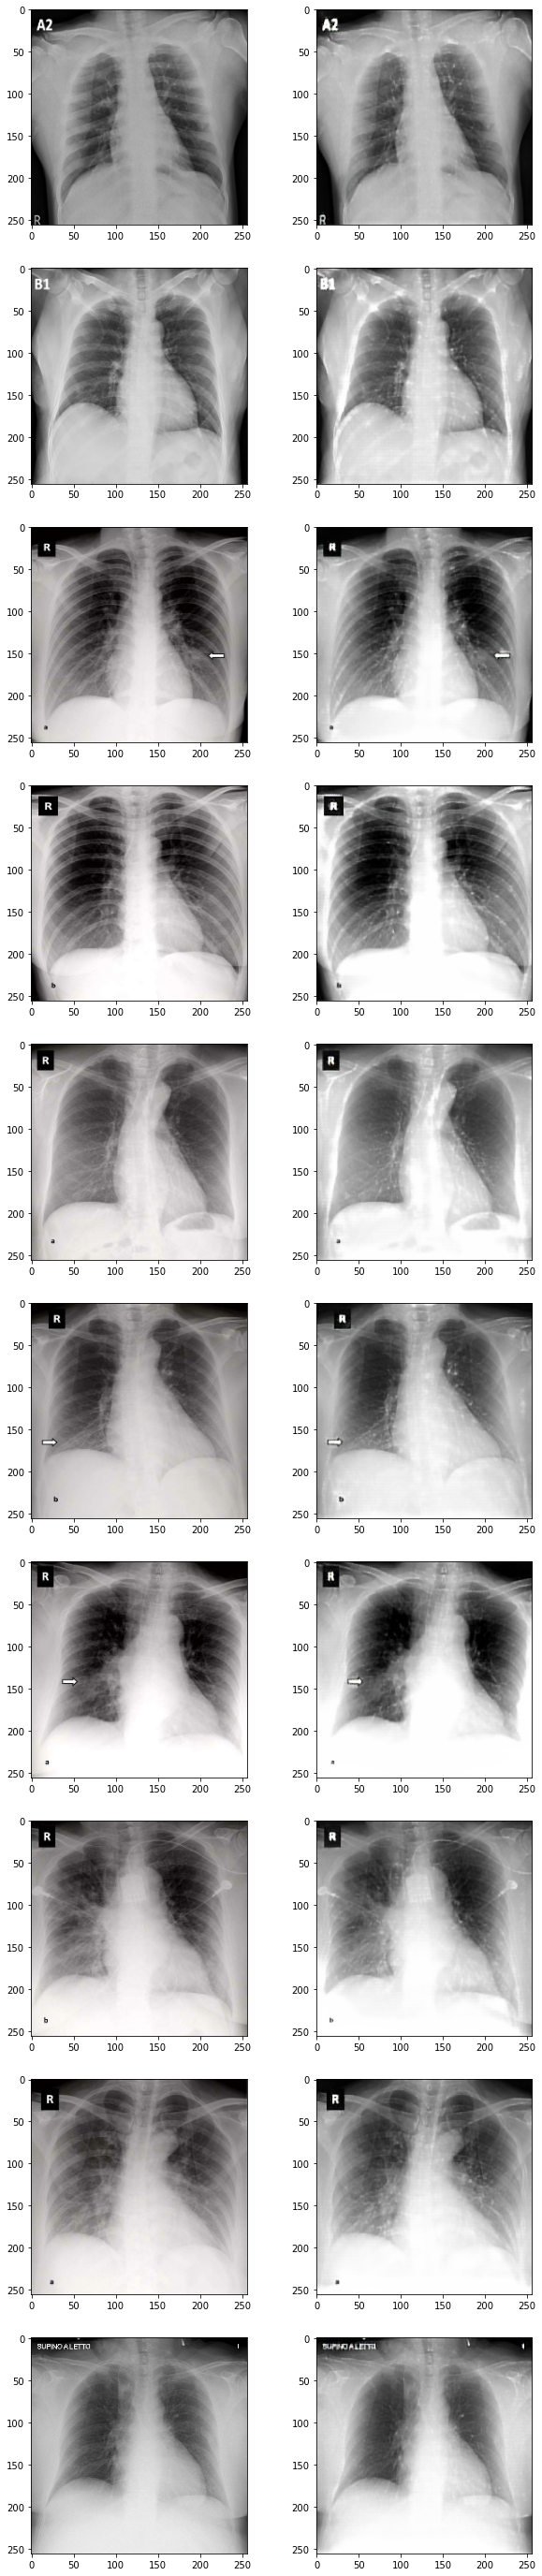

In [20]:
k = 0
plt.figure(figsize=(10,50))
plt.subplot(10,2,1),plt.imshow(bone_X[k])
plt.subplot(10,2,2),plt.imshow(results[k])

plt.subplot(10,2,3),plt.imshow(bone_X[k+1])
plt.subplot(10,2,4),plt.imshow(results[k+1])

plt.subplot(10,2,5),plt.imshow(bone_X[k+2])
plt.subplot(10,2,6),plt.imshow(results[k+2])

plt.subplot(10,2,7),plt.imshow(bone_X[k+3])
plt.subplot(10,2,8),plt.imshow(results[k+3])

plt.subplot(10,2,9),plt.imshow(bone_X[k+4])
plt.subplot(10,2,10),plt.imshow(results[k+4])

plt.subplot(10,2,11),plt.imshow(bone_X[k+5])
plt.subplot(10,2,12),plt.imshow(results[k+5])

plt.subplot(10,2,13),plt.imshow(bone_X[k+6])
plt.subplot(10,2,14),plt.imshow(results[k+6])

plt.subplot(10,2,15),plt.imshow(bone_X[k+7])
plt.subplot(10,2,16),plt.imshow(results[k+7])

plt.subplot(10,2,17),plt.imshow(bone_X[k+8])
plt.subplot(10,2,18),plt.imshow(results[k+8])

plt.subplot(10,2,19),plt.imshow(bone_X[k+9])
plt.subplot(10,2,20),plt.imshow(results[k+9])

In [21]:
brisque_score = quality_metrics.calculate_brisque(results)
print("Mean BRISQUE = {}, standard deviation = {}".format(sum(brisque_score)/8,stats.stdev(brisque_score)))

Mean BRISQUE = 28.651536215286832, standard deviation = 6.2573865023566855


In [5]:
psnr = quality_metrics.calculate_psnr(bone_Y,results)
ssim = quality_metrics.calculate_ssim(bone_Y,results)
entropy_org,entropy_gen = quality_metrics.calculate_entropy(bone_Y,results)
lap_org, lap_gen = quality_metrics.calculate_variance(bone_Y,results)
mse = quality_metrics.calculate_mse(bone_Y,results)
nmse = quality_metrics.calculate_nmse(bone_Y,results)
brisque_score = quality_metrics.calculate_brisque(results)

In [6]:
import statistics as stats

print("Max PSNR = {}".format(max(psnr)))
print("Mean PSNR = {}, standard deviation = {}".format(sum(psnr)/1000,stats.stdev(psnr)))
print("Mean SSIM = {}, standard deviation = {}".format(sum(ssim)/1000,stats.stdev(ssim)))
print("Mean Shannon entropy of dataset = {}, standard deviation = {}".format(sum(entropy_org)/1000,stats.stdev(entropy_org)))
print("Mean Shannon entropy of generated images = {}, standard deviation = {}".format(sum(entropy_gen)/1000,stats.stdev(entropy_gen)))
print("Mean Laplace variance of generated images = {}, standard deviation = {}".format(sum(lap_org)/1000,stats.stdev(lap_org)))
#print("Mean Laplace variance of generated images = {}, standard deviation = {}".format(sum(lap_gen)/1000,stats.stdev(lap_gen)))
print("Mean MSE = {}, standard deviation = {}".format(sum(mse)/1000,stats.stdev(mse)))
print("Mean NMSE = {}, standard deviation = {}".format(sum(nmse)/1000,stats.stdev(nmse)))
print("Mean BRISQUE = {}, standard deviation = {}".format(sum(brisque_score)/1000,stats.stdev(brisque_score)))

Max PSNR = 41.333961826017934
Mean PSNR = 33.2763525859123, standard deviation = 3.6706358481743435
Mean SSIM = 0.9669393530935584, standard deviation = 0.009847954933393422
Mean Shannon entropy of dataset = 6.524928685307242, standard deviation = 0.32334929504382737
Mean Shannon entropy of generated images = 17.250021400479202, standard deviation = 0.18196790423506665
Mean Laplace variance of generated images = 0.005130480666295386, standard deviation = 0.0021680303091879305
Mean MSE = 0.0021705976212519056, standard deviation = 0.0029550263053313114
Mean NMSE = 0.0011848175757668733, standard deviation = 0.001645723630034066
Mean BRISQUE = 52.124947134382246, standard deviation = 5.421106366800328


In [7]:
sum(lap_gen)/1000

0.002972187534236582

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.axes._subplots.AxesSubplot at 0x20f1788c220>,
 <matplotlib.image.AxesImage at 0x20f17a81100>)

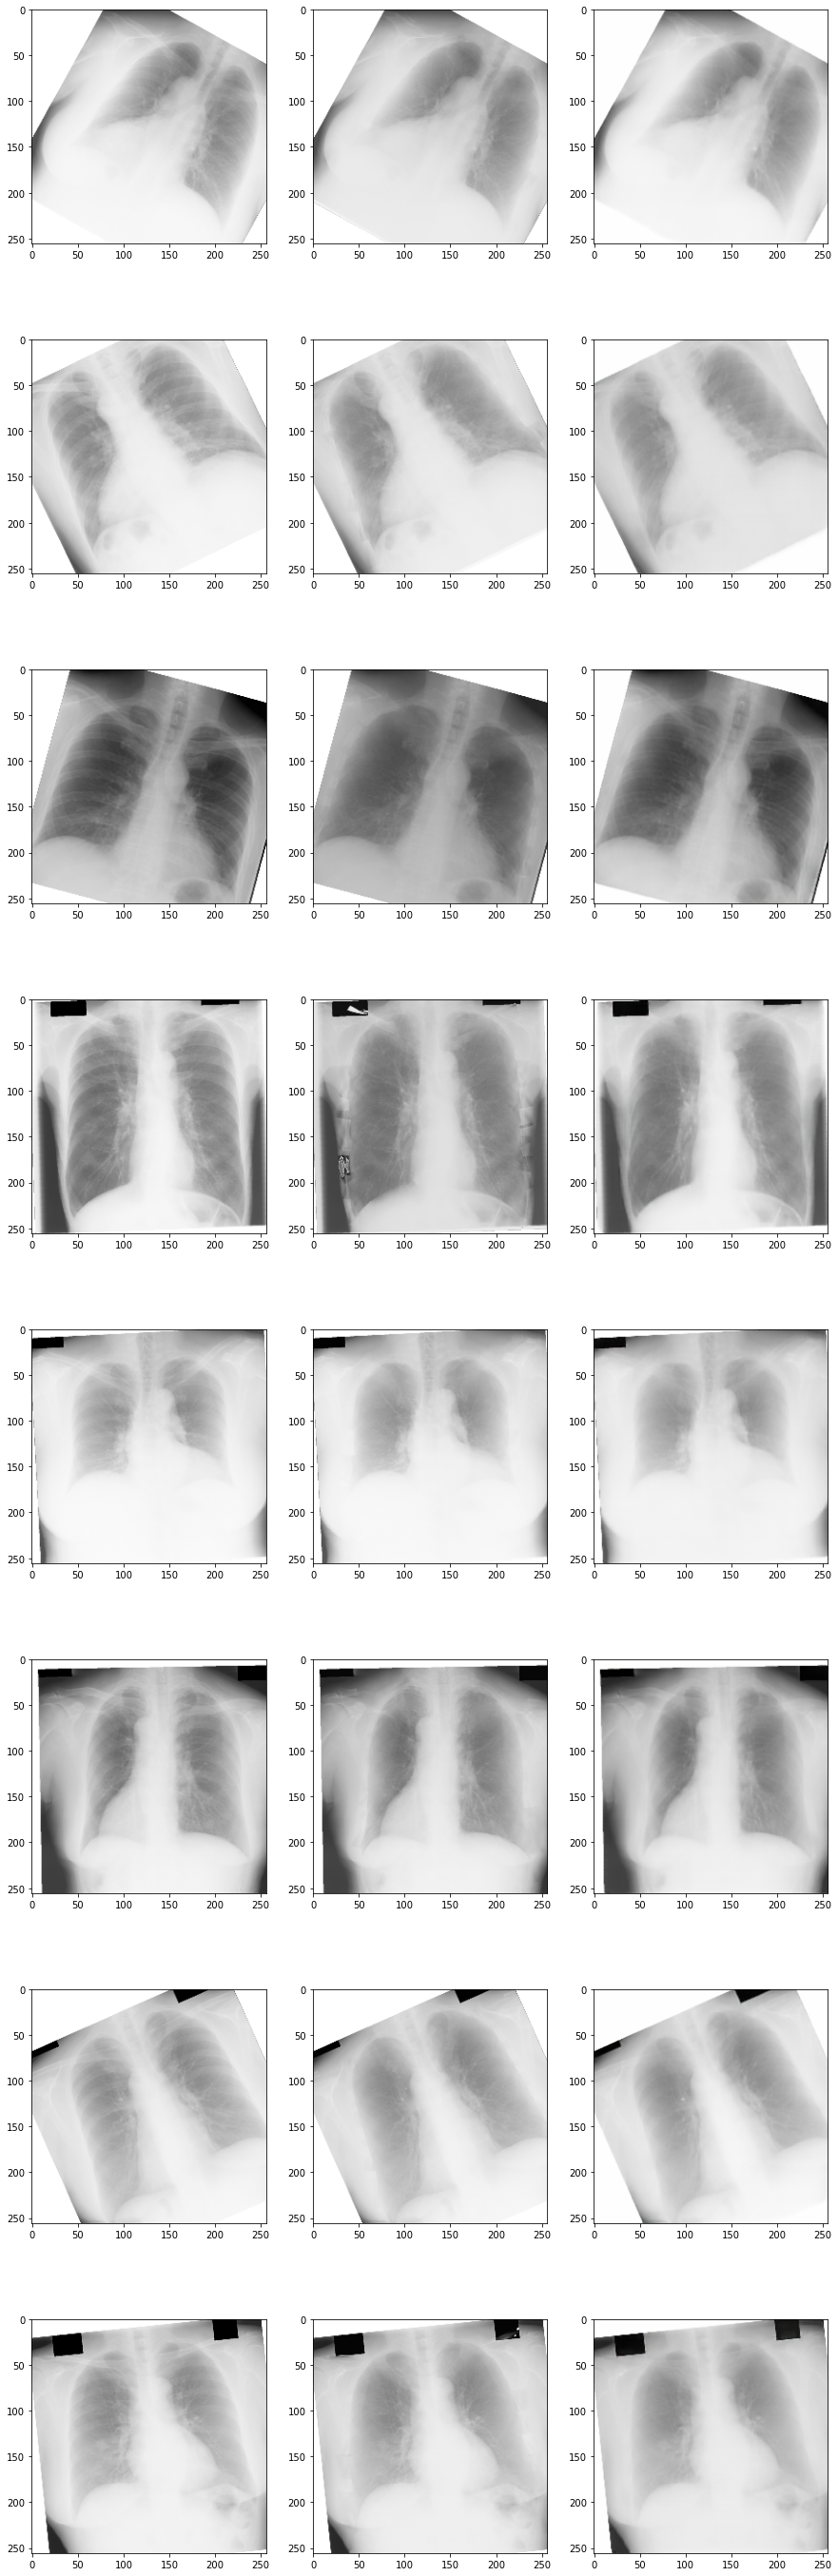

In [8]:
k = 0
plt.figure(figsize=(15,50))
plt.subplot(8,3,1),plt.imshow(bone_X[k])
plt.subplot(8,3,2),plt.imshow(bone_Y[k])
plt.subplot(8,3,3),plt.imshow(results[k])

plt.subplot(8,3,4),plt.imshow(bone_X[k+1])
plt.subplot(8,3,5),plt.imshow(bone_Y[k+1])
plt.subplot(8,3,6),plt.imshow(results[k+1])

plt.subplot(8,3,7),plt.imshow(bone_X[k+2])
plt.subplot(8,3,8),plt.imshow(bone_Y[k+2])
plt.subplot(8,3,9),plt.imshow(results[k+2])

plt.subplot(8,3,10),plt.imshow(bone_X[k+3])
plt.subplot(8,3,11),plt.imshow(bone_Y[k+3])
plt.subplot(8,3,12),plt.imshow(results[k+3])

plt.subplot(8,3,13),plt.imshow(bone_X[k+4])
plt.subplot(8,3,14),plt.imshow(bone_Y[k+4])
plt.subplot(8,3,15),plt.imshow(results[k+4])

plt.subplot(8,3,16),plt.imshow(bone_X[k+5])
plt.subplot(8,3,17),plt.imshow(bone_Y[k+5])
plt.subplot(8,3,18),plt.imshow(results[k+5])

plt.subplot(8,3,19),plt.imshow(bone_X[k+6])
plt.subplot(8,3,20),plt.imshow(bone_Y[k+6])
plt.subplot(8,3,21),plt.imshow(results[k+6])

plt.subplot(8,3,22),plt.imshow(bone_X[k+7])
plt.subplot(8,3,23),plt.imshow(bone_Y[k+7])
plt.subplot(8,3,24),plt.imshow(results[k+7])